## Imports

In [209]:
import collections
import gymnasium as gym
import itertools
import numpy as np
from numpy.typing import NDArray
import pandas as pd
import random
import time
import torch
from torch.optim.lr_scheduler import _LRScheduler
from typing import List, Tuple, Deque, Optional, Callable
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from GolfField import GolfField, Point, Ball
from GolfEnv import GolfEnv, GolfEnv8d1p
from utils import QNetwork, MinimumExponentialLR, EpsilonGreedy, ReplayBuffer, train_dqn2_agent, get_episode_len, train_naive_agent

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Standart reward

1


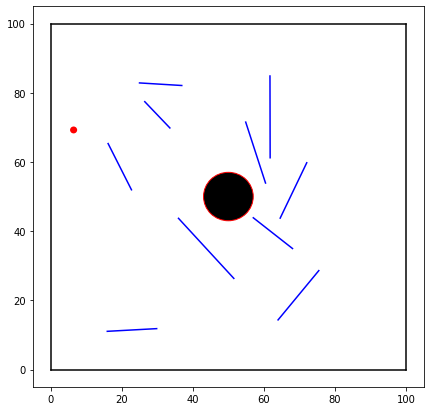

In [197]:
env = GolfEnv8d1p(0, 10, lambda old_dist, new_dist: 0)
env.field.hole_R = 7
env.reset()
env.field.hole = Ball(Point(50, 50), 7)
env.render()
print(env.field.gameball_R)

In [198]:
device = 'cpu'

state_dim = 2
action_dim = 8

q_network = QNetwork(state_dim, action_dim, nn_l1=128, nn_l2=128).to(device)
target_q_network = QNetwork(state_dim, action_dim, nn_l1=128, nn_l2=128).to(device)
target_q_network.load_state_dict(q_network.state_dict())

optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.004, amsgrad=True)
#lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=0.0001)
loss_fn = torch.nn.MSELoss()

epsilon_greedy = EpsilonGreedy(epsilon_start=0.82, epsilon_min=0.013, epsilon_decay=0.9675, env=env, q_network=q_network)

replay_buffer = ReplayBuffer(2000)

In [199]:
# Train the q-network

episode_reward_list = train_dqn2_agent(env,
                                       q_network,
                                       target_q_network,
                                       optimizer,
                                       loss_fn,
                                       epsilon_greedy,
                                       device,
                                       lr_scheduler,
                                       num_episodes=500,
                                       gamma=0.9,
                                       batch_size=128,
                                       replay_buffer=replay_buffer,
                                       target_q_network_sync_period=30)

 10%|▉         | 49/499 [00:31<04:46,  1.57it/s]

102.04081632653062


 20%|██        | 101/499 [01:12<04:07,  1.61it/s]

260.0


 30%|██▉       | 149/499 [01:44<02:59,  1.95it/s]

280.0


 40%|███▉      | 199/499 [02:25<03:19,  1.51it/s]

120.0


 50%|████▉     | 249/499 [03:00<02:21,  1.76it/s]

240.0


 60%|█████▉    | 299/499 [03:34<02:36,  1.27it/s]

280.0


 70%|███████   | 350/499 [04:11<00:56,  2.62it/s]

360.0


 80%|███████▉  | 399/499 [04:45<01:22,  1.22it/s]

280.0


 90%|████████▉ | 449/499 [05:25<00:35,  1.40it/s]

180.0


100%|██████████| 499/499 [06:12<00:00,  1.34it/s]

0.0


In [246]:
def get_episode_len1(env, q_network, epsilon_greedy, device='cpu'):
    state, info = env.reset()
    episode_len = 0

    for t in itertools.count():
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        action_dist = q_network(state_tensor).squeeze()
        action = epsilon_greedy(state)

        state, reward, done, truncated, _ = env.step(action)
        if done:
            break
        episode_len += 1

    return episode_len

In [202]:
lens = np.array([get_episode_len(env, q_network, epsilon_greedy) for i in tqdm(range(100))])
print('Mean route len:', np.mean(lens))
print('Success rate:', np.mean(lens < 99))

100%|██████████| 100/100 [00:46<00:00,  2.16it/s]

Mean route len: 89.82
Success rate: 0.1


## Closer +1/Further -1 reward

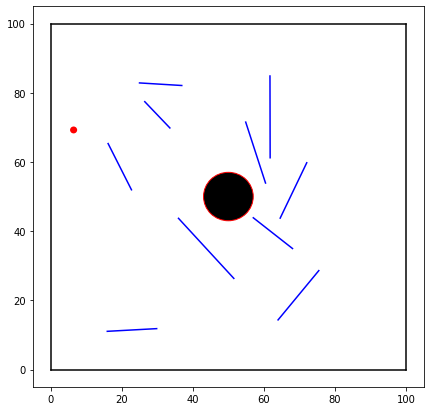

In [228]:
env = GolfEnv8d1p(0, 10, lambda old_dist, new_dist: ((new_dist < old_dist) * 2 - 1) * 100)
env.field.hole_R = 7
env.reset()
env.field.hole = Ball(Point(50, 50), 7)
env.render()

In [229]:
device = 'cpu'

state_dim = 2
action_dim = 8

q_network = QNetwork(state_dim, action_dim, nn_l1=128, nn_l2=128).to(device)
target_q_network = QNetwork(state_dim, action_dim, nn_l1=128, nn_l2=128).to(device)
target_q_network.load_state_dict(q_network.state_dict())

optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.004, amsgrad=True)
#lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=0.0001)
loss_fn = torch.nn.MSELoss()

epsilon_greedy = EpsilonGreedy(epsilon_start=0.82, epsilon_min=0.013, epsilon_decay=0.9675, env=env, q_network=q_network)

replay_buffer = ReplayBuffer(2000)

In [230]:
episode_reward_list = train_dqn2_agent(env,
                                       q_network,
                                       target_q_network,
                                       optimizer,
                                       loss_fn,
                                       epsilon_greedy,
                                       device,
                                       lr_scheduler,
                                       num_episodes=500,
                                       gamma=0.9,
                                       batch_size=128,
                                       replay_buffer=replay_buffer,
                                       target_q_network_sync_period=30)

 10%|▉         | 49/499 [00:32<03:33,  2.10it/s]

11944.897959183674


 20%|█▉        | 99/499 [01:16<09:33,  1.43s/it]

5728.0


 30%|██▉       | 149/499 [01:58<03:21,  1.73it/s]

8312.0


 40%|███▉      | 199/499 [02:34<05:12,  1.04s/it]

10246.0


 50%|████▉     | 249/499 [03:21<03:05,  1.35it/s]

9860.0


 60%|██████    | 300/499 [04:01<01:52,  1.76it/s]

14226.0


 70%|██████▉   | 349/499 [04:48<02:42,  1.08s/it]

23888.0


 80%|███████▉  | 399/499 [05:43<01:33,  1.08it/s]

22788.0


 90%|████████▉ | 449/499 [06:31<00:59,  1.19s/it]

23420.0


100%|██████████| 499/499 [07:23<00:00,  1.13it/s]

25704.0


In [248]:
lens = np.array([get_episode_len1(env, q_network, epsilon_greedy) for i in tqdm(range(100))])
print('Mean route len:', np.mean(lens))
print('Success rate:', np.mean(lens < 99))

100%|██████████| 100/100 [00:40<00:00,  2.47it/s]

Mean route len: 66.29
Success rate: 0.37


## Subtract new_dist reward

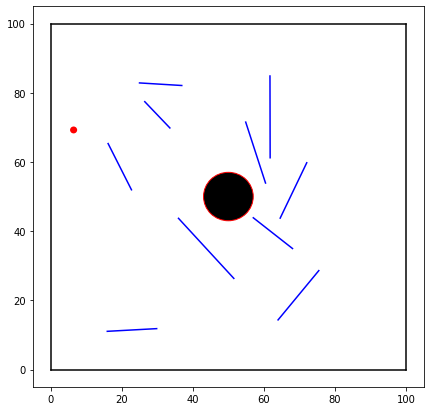

In [207]:
env = GolfEnv8d1p(0, 10, lambda old_dist, new_dist: -new_dist)
env.field.hole_R = 7
env.reset()
env.field.hole = Ball(Point(50, 50), 7)
env.render()

In [210]:
device = 'cpu'

state_dim = 2
action_dim = 8

q_network = QNetwork(state_dim, action_dim, nn_l1=128, nn_l2=128).to(device)
target_q_network = QNetwork(state_dim, action_dim, nn_l1=128, nn_l2=128).to(device)
target_q_network.load_state_dict(q_network.state_dict())

optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.004, amsgrad=True)
#lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=0.0001)
loss_fn = torch.nn.MSELoss()

epsilon_greedy = EpsilonGreedy(epsilon_start=0.82, epsilon_min=0.013, epsilon_decay=0.9675, env=env, q_network=q_network)

replay_buffer = ReplayBuffer(2000)

In [211]:
episode_reward_list = train_dqn2_agent(env,
                                       q_network,
                                       target_q_network,
                                       optimizer,
                                       loss_fn,
                                       epsilon_greedy,
                                       device,
                                       lr_scheduler,
                                       num_episodes=500,
                                       gamma=0.9,
                                       batch_size=128,
                                       replay_buffer=replay_buffer,
                                       target_q_network_sync_period=30)

 10%|█         | 50/499 [00:25<03:35,  2.09it/s]

-2204.0800556066083


 20%|█▉        | 99/499 [01:01<05:50,  1.14it/s]

-1717.212975258827


 30%|██▉       | 149/499 [01:33<04:16,  1.36it/s]

-2341.533872385025


 40%|███▉      | 199/499 [02:30<04:41,  1.07it/s]

-1996.5386127233505


 50%|████▉     | 249/499 [03:21<05:09,  1.24s/it]

-1385.689086637497


 60%|█████▉    | 299/499 [04:14<03:20,  1.00s/it]

-1678.4946650266647


 70%|██████▉   | 349/499 [05:14<03:29,  1.39s/it]

-1633.5563047409057


 80%|███████▉  | 399/499 [06:04<01:28,  1.13it/s]

-1619.7458615589142


 90%|████████▉ | 449/499 [06:53<00:52,  1.06s/it]

-1525.0904069805144


100%|██████████| 499/499 [07:37<00:00,  1.09it/s]

-1401.1637765073776


In [212]:
lens = np.array([get_episode_len(env, q_network, epsilon_greedy) for i in tqdm(range(100))])
print('Mean route len:', np.mean(lens))
print('Success rate:', np.mean(lens < 99))

100%|██████████| 100/100 [00:29<00:00,  3.35it/s]

Mean route len: 88.42
Success rate: 0.14


99


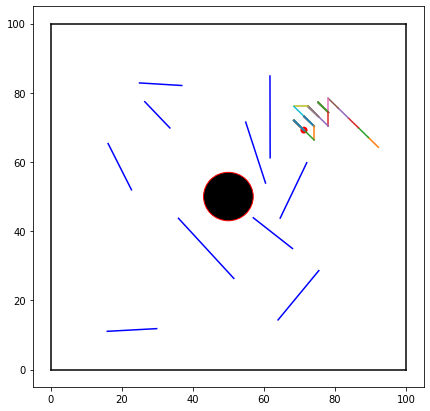

In [219]:
print(get_episode_len(env, q_network, epsilon_greedy))
env.render()